[(0, 230), (0, 230), (0, 230), (0, 230)]
           constr: [array([0., 0., 0., 0., 0., 0.])]
 constr_violation: 0.0
              fun: 2831.090119048309
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 10480
              nit: 233
          success: True
                x: array([1.01182027e-02, 4.00366647e-01, 4.45389178e+01, 3.30625748e-01])
Service Time -> [ 0  0 45  0  2  4]
Coverage->  [62 52  0 90 13 11]
Safety Stock->  [238 204   0 269 151 149]
Total Cost->  2831
SE Safety Stock->  [234 200 196 190 162 174]
SE Total Cost->  3179


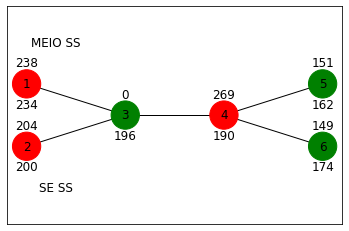

In [15]:
%reset -f
import numpy as np
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint
from scipy.optimize import LinearConstraint
from scipy.stats import norm
import math
import pandas as pd

file_loc = "GSM_Hybrid_Input.xlsx"
df = pd.read_excel(file_loc, index_col=None)

LT = np.array(df['LEAD_TIME'])
Product_Cost = np.array(df['PRODUCT_COST'])
Holding_Cost = np.array(df['HOLDING_COST_%'])
Demand = np.array(df['DEMAND'])
Std_dev = np.array(df['STD_DEVIATION'])
LT_Std_dev=np.array(df['LT_STD_DEV'])
Q = np.array([750,500,1000,2000,2000,2000])
SL = np.array(df['SERVICE_LEVEL'])
ST_Node0 = df.iloc[0, 11]
ST_Node00 = df.iloc[1, 11]
ST_Node5 = df.iloc[4, 10]
ST_Node6 = df.iloc[5, 10]
LT_sum=np.sum(LT)
k=norm.ppf(SL)


def opt(x):
    
    ST=np.array([x[0],x[1],x[2],x[3],ST_Node5,ST_Node6])
    ST=np.round(ST)
    Coverage = np.zeros((6))
    Coverage[0]=LT[0]+ST_Node0-ST[0]
    Coverage[1]=LT[1]+ST_Node00-ST[1]
    Coverage[2]=LT[2]+ST[0]+ST[1]-ST[2]
    for i in range(3,5):
        Coverage[i]=LT[i]+ST[i-1]-ST[i]
    Coverage[5]=LT[5]+ST[3]-ST[5]
    Safety_Stock= k*(((Coverage/30)*(Std_dev**2))+(LT_Std_dev*(LT/30)*Demand)**2)**(1/2) 
    Total_Cost= (Safety_Stock)*Product_Cost*Holding_Cost
    #Total_Cost=[10e5 if math.isnan(x) else x for x in Total_Cost]
    Cost=np.sum(Total_Cost)
    return Cost

#def constraint1(x):

def constraint1(x):
    ST=np.array([x[0],x[1],x[2],x[3],ST_Node5,ST_Node6])
    ST=np.round(ST)
    Coverage = np.zeros((6))
    Coverage[0]=LT[0]+ST_Node0-ST[0]
    Coverage[1]=LT[1]+ST_Node00-ST[1]
    Coverage[2]=LT[2]+ST[0]+ST[1]-ST[2]
    for i in range(3,5):
        Coverage[i]=LT[i]+ST[i-1]-ST[i]
    Coverage[5]=LT[5]+ST[3]-ST[5]
    return Coverage
    

cons1=NonlinearConstraint(constraint1,0,LT_sum)
#print(cons1)

bounds = [(0, LT_sum), (0, LT_sum), (0, LT_sum),(0, LT_sum)]
print(bounds)


result = differential_evolution(opt,bounds,constraints=[cons1],tol=0.0001, mutation=(0.5, 1.9),init='random',popsize=30)
result.x, result.fun
a=result.x
ST1 = np.array([a[0],a[1],a[2],a[3],ST_Node5,ST_Node6])
ST1=np.round(ST1)
ST1=ST1.astype(int)
print(result)
print("Service Time ->",ST1)

#Recalculation for output

Coverage = np.zeros((6))
Coverage[0]=LT[0]+ST_Node0-ST1[0]
Coverage[1]=LT[1]+ST_Node00-ST1[1]
Coverage[2]=LT[2]+ST1[0]+ST1[1]-ST1[2]
for i in range(3,5):
    Coverage[i]=LT[i]+ST1[i-1]-ST1[i]
Coverage[5]=LT[5]+ST1[3]-ST1[5]
Safety_Stock= k*(((Coverage/30)*(Std_dev**2))+(LT_Std_dev*(LT/30)*Demand)**2)**(1/2)
Total_Cost= (Safety_Stock)*Product_Cost*Holding_Cost
Cost=round(np.sum(Total_Cost))

safety_stock = np.array(Safety_Stock)
safety_stock=safety_stock.astype(int)
Cost=np.array(Cost)
Cost=Cost.astype(int)
Coverage=Coverage.astype(int)
print("Coverage-> ",Coverage)
print("Safety Stock-> ",safety_stock)
print("Total Cost-> ",Cost)

SE_Safety_Stock = np.zeros(6)
SE_Safety_Stock= k*(((LT/30)*(Std_dev**2))+(LT_Std_dev*(LT/30)*Demand)**2)**(1/2)
SE_Total_Cost= (SE_Safety_Stock)*Product_Cost*Holding_Cost
SE_Cost=round(np.sum(SE_Total_Cost))
SE_Safety_Stock=SE_Safety_Stock.astype(int)
SE_Total_Cost=SE_Total_Cost.astype(int)
SE_Cost=SE_Cost.astype(int)
print("SE Safety Stock-> ",SE_Safety_Stock)
print("SE Total Cost-> ",SE_Cost)

#network graph display trial

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

MEIO_SS = safety_stock
SE_SS = SE_Safety_Stock

nxG=nx.Graph()

NxNodeList= [1,2,3,4,5,6]
nxG.add_nodes_from(NxNodeList)

NxEdgeList= [(1,3),(2,3),(3,4),(4,5),(4,6)]
nxG.add_edges_from(NxEdgeList)

pos = {1: [0,.03],
       2: [0,-.03],
       3: [1,0],
       4: [2,0],
       5: [3,.03],
       6: [3,-.03]}

color_map=[]
size_map=[]

for i in nxG.nodes:
    if MEIO_SS[i-1]<SE_SS[i-1]:
        color_map.append('green')
    else:
        color_map.append('red')

pos1 = {1: [0,.05],
        2: [0,-.01],
        3: [1,.02],
        4: [2,.02],
        5: [3,.05],
        6: [3,-.01]}

label1=dict(zip(NxNodeList,MEIO_SS))

pos2 = {1: [0,.01],
        2: [0,-.05],
        3: [1,-.02],
        4: [2,-.02],
        5: [3,.01],
        6: [3,-.05]}

label2=dict(zip(NxNodeList,SE_SS))
sizes=[800,800,800,800,800,800]

pos3={1:[0.3,0.07]}
label3={1:'MEIO SS'}

pos4={1:[0.3,-0.07]}
label4={1:'SE SS'}

nx.draw_networkx(nxG, pos, nodelist=NxNodeList,node_color=color_map,node_size=sizes)
nx.draw_networkx_labels(nxG, pos1, label1, font_size=12)
nx.draw_networkx_labels(nxG, pos2, label2, font_size=12)
nx.draw_networkx_labels(nxG, pos3, label3, font_size=12)
nx.draw_networkx_labels(nxG, pos4, label4, font_size=12)

plt.savefig("GSM network.png")